# Reinforcement Learning - Deep Q Learning

> In this lab, you're going to:

1.   Use PyTorch to train a Deep Q Learning (DQN) agent on the CartPole-v1 task from the [OpenAI Gym](https://gym.openai.com/).
2.   Use **experience replay memory** for training your DQN agent.
3.   Create a simple plot to visualize your agent's efficiency.

### Description



In Cartpole, a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pole starts upright, and the goal is to prevent it from falling over. The system is controlled by applying a force of +1 or -1 to the cart. A reward of +1 is provided for every timestep that the pole remains upright. The **episode ends** when **the pole is more than 15 degrees from vertical**, or **the cart moves more than 2.4 units from the center of the track**.

![](https://pytorch.org/tutorials/_images/cartpole.gif)

In [8]:
### Instantiate the Cartpole environment ###
import gym
env = gym.make("CartPole-v1")
env.seed(1)

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


[1]

Given this setup for the environment and the objective of the game, we can think about:
- 1) What observations help define the environment's state;
- 2) What actions the agent can take.


First, let's consider the observation space. In this Cartpole environment, our observations are:
- Cart position
- Cart velocity
- Pole angle
- Pole rotation rate

We can confirm the size of the space by querying the environment's observation space:

In [9]:
n_observations = env.observation_space
print("Environment has observation space =", n_observations)

Environment has observation space = Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


Second, we consider the action space. At every time step, the agent can move either **right** or **left**. Again, we can confirm the size of the action space by querying the environment:

In [10]:
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

Number of possible actions that the agent can choose from = 2


### Solved Requirements

Considered solved when the average reward is **greater than or equal to 450.0 over 100 consecutive trials**.

### Packages

Let’s import the needed packages. In this lab, you will use the following from PyTorch:

- neural networks (`torch.nn`)
- optimization (`torch.optim`)
- automatic differentiation (`torch.autograd`)

In [11]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import randint

In [12]:
env = gym.make('CartPole-v1')

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## The Behavior of a Random Agent


We will first check the average reward that a random agent can earn. By **Random Agent**, we're referring to an agent selecting actions randomly (i.e. without using any environmental information). Running this snippet gave an average reward in range *(20, 25)*. It may vary slightly in your case. But still, the problem is far from solved.

In [13]:
rew_arr = []
episode_count = 100
for i in range(episode_count):
    obs, done, rew = env.reset(), False, 0
    while (done != True) :
        A =  randint(0, env.action_space.n, (1,))
        obs, reward, done, info = env.step(A.item())
        rew += reward
    rew_arr.append(rew)

print("Average reward/episode :",sum(rew_arr)/ len(rew_arr))

Average reward/episode : 22.22


Now, let's define our model. But first, let's quickly recap what a DQN is.
## DQN algorithm

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. It makes rewards from the uncertain far
future less important for our agent than the ones in the near future
that it can be fairly confident about.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the [MSE
loss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html).


### Model Architecture

In [14]:
class QNetwork(nn.Module):
  def __init__(self, state_size, action_size, seed):
    """
    Initialize parameters and build model.
    Params:
      - state_size (int): Dimension of each state
      - action_size (int): Dimension of each action
      - seed (int): Random seed
      - fc1_unit (int): Number of nodes in first hidden layer
      - fc2_unit (int): Number of nodes in second hidden layer
    """
    super(QNetwork, self).__init__()
    self.seed = torch.manual_seed(seed)

    ### YOUR CODE HERE ###
    self.state_size = state_size
    self.action_size = action_size
    self.fc1 = nn.Linear(state_size, 64)
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, action_size)
    None
    ### END ###

  def forward(self, state):
    """
    Build a network that maps state -> action values.
    """
    ### YOUR CODE HERE ###
    x = F.relu(self.fc1(state))
    x = F.relu(self.fc2(x))
    return self.fc3(x)
    ### END ###

### DQN Agent

In this Lab, we will use Soft update in DQN network.

![](https://greentec.github.io/images/rl3_7-en.png)

A **soft update** means that we do not update this target network at once, but **frequently and very little**. The value of $τ$ is used. In Deepmind’s paper, which proposed an algorithm called DPG, they used $τ=0.001$. The target network is updated as follows:

<center>
$θ_{target} = τ*θ_{local} + (1 - τ)*θ_{target}$
</center>

The target network will move slightly to the value of Q-network. Since the value of $τ$ is small, the update should be frequent so that the effect will be noticeable.



#### Hyperparameters

In [15]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
UPDATE_EVERY = 4

#### Agent

In [16]:
class Agent():
  """
  Interacts with and learns form environment.
  """

  def __init__(self, state_size, action_size, seed):
    """
    Initialize an Agent object.
    Params:
      - state_size (int): dimension of each state
      - action_size (int): dimension of each action
      - seed (int): random seed
    """

    self.state_size = state_size
    self.action_size = action_size
    self.seed = random.seed(seed)

    self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
    self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)

    self.optimizer = optim.Adam(self.qnetwork_local.parameters())

    self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
    self.t_step = 0

  def step(self, state, action, reward, next_step, done):
    self.memory.add(state, action, reward, next_step, done)
    self.t_step = (self.t_step+1) % UPDATE_EVERY
    if self.t_step == 0:
      if len(self.memory) > BATCH_SIZE:
        experience = self.memory.sample()
        self.learn(experience, GAMMA)


  def act(self, state, eps = 0):
    """
    Returns action for given state as per current policy.
    Params:
      - state (array_like): current state
      - eps (float): epsilon, for epsilon-greedy action selection
    """
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    self.qnetwork_local.eval()
    with torch.no_grad():
      action_values = self.qnetwork_local(state)
    self.qnetwork_local.train()

    # Epsilon-greedy action selction
    if random.random() > eps:
      return np.argmax(action_values.cpu().data.numpy())
    else:
      return random.choice(np.arange(self.action_size))

  def learn(self, experiences, gamma):
    """
    Update value parameters using given batch of experience tuples.
    Params:
      - experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
      - gamma (float): discount factor
    """
    states, actions, rewards, next_states, dones = experiences

    ### YOUR CODE HERE ###
    Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
    Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
    Q_expected = self.qnetwork_local(states).gather(1, actions)

    # Compute loss
    loss = F.mse_loss(Q_expected, Q_targets)

    # Minimize the loss
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    ### END ###

    # ------------------- update target network ------------------- #
    self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

  def soft_update(self, local_model, target_model, tau):
    """
    Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target

    Params:
      - local model (PyTorch model): weights will be copied from
      - target model (PyTorch model): weights will be copied to
      - tau (float): interpolation parameter
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)

#### Replay Memory


We’ll be using experience replay memory for training our DQN. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

In [17]:
class ReplayBuffer:
  """
  Fixed-size buffe to store experience tuples.
  """
  def __init__(self, action_size, buffer_size, batch_size, seed):
    """
    Initialize a ReplayBuffer object.
    Params:
      - action_size (int): dimension of each action
      - buffer_size (int): maximum size of buffer
      - batch_size (int): size of each training batch
      - seed (int): random seed
    """
    self.action_size = action_size
    self.memory = deque(maxlen=buffer_size)
    self.batch_size = batch_size
    self.experiences = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    self.seed = random.seed(seed)

  def add(self,state, action, reward, next_state,done):
    """
    Add a new experience to memory.
    """
    e = self.experiences(state,action,reward,next_state,done)
    self.memory.append(e)

  def sample(self):
    """
    Randomly sample a batch of experiences from memory.
    """
    experiences = random.sample(self.memory, k=self.batch_size)

    states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
    actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
    rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
    next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
    dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

    return (states,actions,rewards,next_states,dones)

  def __len__(self):
    """
    Return the current size of internal memory.
    """
    return len(self.memory)

### Train the Agent with DQN

In [18]:
# Init agent
agent = Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=0)

In [27]:
def DQN(n_episodes= 10000, eps_start=0.9, eps_end = 0.01, eps_decay=0.9):
  """
  Deep Q-Learning
  Params:
    - n_episodes (int): maximum number of training epsiodes
    - eps_start (float): starting value of epsilon, for epsilon-greedy action selection
    - eps_end (float): minimum value of epsilon
    - eps_decay (float): mutiplicative factor (per episode) for decreasing epsilon
  """
  scores = []
  scores_window = deque(maxlen=100)  # last 100 scores
  eps = eps_start
  for i_episode in range(n_episodes):
    state, score, done = env.reset(), 0, False

    while(done != True):
      action = agent.act(state, eps)
      next_state, reward, done, _ = env.step(action)
      agent.step(state, action, reward, next_state, done)

      state = next_state
      score += reward
      # decrease the epsilon
      eps = max(eps*eps_decay, eps_end)

      # print('\rEpisode {}\tScore {:.2f}'.format(i_episode, np.mean(score)), end="")

    scores.append(score)
    scores_window.append(score)
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    if np.mean(scores_window) >= 450.0:
      print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
      torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
      break
  return scores

In [ ]:
scores = DQN()

Episode 69	Average Score: 450.43
Environment solved in -31 episodes!	Average Score: 450.43


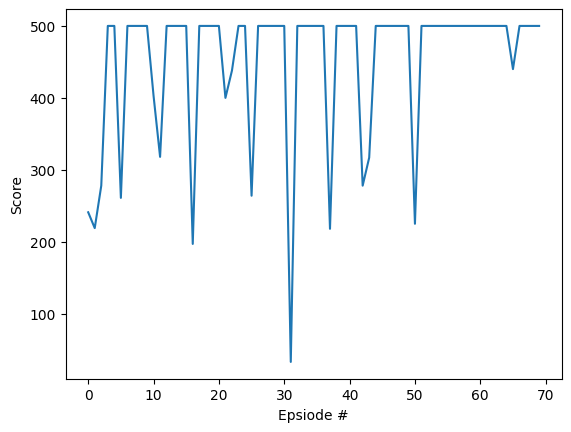

In [ ]:
#plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)),scores)
plt.ylabel('Score')
plt.xlabel('Epsiode #')
plt.show()

## Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment. To continue your learning, you are encouraged to complete any (or all!) of the following tasks:

- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster. Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN!
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.